### Read Data

In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\samue\OneDrive - HKUST Connect\year 2 spring\UROP 1100\UROP-1100-21S\source_bias\labelled_news_data.csv")
df.head()

,id,title,publication,author,date,year,month,url,content,media_bias,label
0,82596,Donald Trump blasts Bill Clinton as ’one of th...,Fox News,Christopher Snyder,2015-12-30,2015.0,12.0,https://web.archive.org/web/20160101000951/htt...,Donald Trump launched new attacks against Bil...,right,POLITICS
1,82600,"Drop in oil prices rocks producer states, trig...",Fox News,Brooke Singman,2016-01-01,2016.0,1.0,https://web.archive.org/web/20160102032517/htt...,The plunge in oil prices has given a needed b...,right,BUSINESS
2,82605,Open carry comes to Texas: Why the Lone Star s...,Fox News,John R Lott,2015-12-30,2015.0,12.0,https://web.archive.org/web/20160102032517/htt...,"With about 900, 000 concealed handgun permit ...",right,POLITICS
3,82621,GOP field rips Obama’s move toward executive a...,Fox News,Joseph Weber,2016-01-03,2016.0,1.0,https://web.archive.org/web/20160104001421/htt...,Republican presidential candidates are attack...,right,POLITICS
4,82630,President Obama wants to disarm America,Fox News,Todd Starnes,2016-01-04,2016.0,1.0,https://web.archive.org/web/20160105014544/htt...,President Obama is plotting with his attorney...,right,POLITICS


In [2]:
politics = df[df['label'] == "POLITICS"]
politics.head()

,id,title,publication,author,date,year,month,url,content,media_bias,label
0,82596,Donald Trump blasts Bill Clinton as ’one of th...,Fox News,Christopher Snyder,2015-12-30,2015.0,12.0,https://web.archive.org/web/20160101000951/htt...,Donald Trump launched new attacks against Bil...,right,POLITICS
2,82605,Open carry comes to Texas: Why the Lone Star s...,Fox News,John R Lott,2015-12-30,2015.0,12.0,https://web.archive.org/web/20160102032517/htt...,"With about 900, 000 concealed handgun permit ...",right,POLITICS
3,82621,GOP field rips Obama’s move toward executive a...,Fox News,Joseph Weber,2016-01-03,2016.0,1.0,https://web.archive.org/web/20160104001421/htt...,Republican presidential candidates are attack...,right,POLITICS
4,82630,President Obama wants to disarm America,Fox News,Todd Starnes,2016-01-04,2016.0,1.0,https://web.archive.org/web/20160105014544/htt...,President Obama is plotting with his attorney...,right,POLITICS
5,82631,"Rancher family reports to prison, does not end...",Fox News,Hollie McKay,2016-01-04,2016.0,1.0,https://web.archive.org/web/20160105014544/htt...,As armed protesters occupied buildings on a f...,right,POLITICS


<AxesSubplot:>

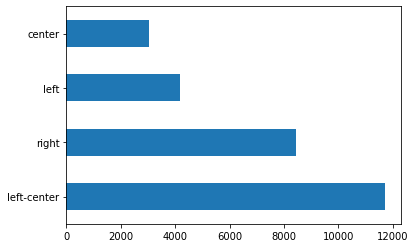

In [3]:
politics.media_bias.value_counts().plot(kind='barh')

### DataFrame to text file

In [4]:
(politics[politics['media_bias'] == 'right']['title'] + ' ' + politics[politics['media_bias'] == 'right']['content']).to_csv(r'right.txt', header=None, index=None, sep=' ', mode='a')

In [5]:
(politics[politics['media_bias'] == 'center']['title'] + ' ' + politics[politics['media_bias'] == 'center']['content']).to_csv(r'center.txt', header=None, index=None, sep=' ', mode='a')

In [6]:
left = (politics['media_bias'] == 'center') | (politics['media_bias'] == 'left-center')
(politics[left]['title'] + ' ' + politics[left]['content']).to_csv(r'left.txt', header=None, index=None, sep=' ', mode='a')

### Train a word2vec model using Keras
[reference link](https://www.tensorflow.org/tutorials/text/word2vec)

In [7]:
import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

In [8]:
%load_ext tensorboard
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=SEED,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [10]:
path_to_file = r"left.txt"
# Use the non empty lines to construct a tf.data.TextLineDataset object for the next step
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

In [11]:
# lowercase the text and remove punctuation.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and the number of words in a sequence.
vocab_size = 8192
sequence_length = 10

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [12]:
# Call TextVectorization.adapt on the text dataset to create vocabulary
vectorize_layer.adapt(text_ds.batch(1024))

In [13]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'the', 'to', 'of', 'a', 'and', 'in', 'that', 'for', 'on', 'is', 'he', 'trump', 'said', 'with', 'as', 'was', 'his', 'it']


In [14]:
# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [15]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

59044


In [16]:
for seq in sequences[:5]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[  83   13  132 3872   32    1  739    3    2  126] => ['donald', 'trump', 'may', 'pose', 'an', '[UNK]', 'threat', 'to', 'the', 'united']
[  13    1 4687  194 1900    1  193    2 2840 7018] => ['trump', '[UNK]', 'dismiss', 'russia', 'scandal', '[UNK]', 'me', 'the', 'proof', '–']
[  13    1 1136    1  654    7 2416    3  341  259] => ['trump', '[UNK]', 'firm', '[UNK]', 'millions', 'in', 'donations', 'to', 'family', 'members']
[1271    1 4897    1 4177    3  255   78   59  306] => ['tom', '[UNK]', 'sends', '[UNK]', 'machine', 'to', 'help', 'white', 'house', 'press']
[   2 2104  100    2    1 4333    2  218  317 7916] => ['the', 'resistance', 'now', 'the', '[UNK]', 'shock', 'the', 'world', 'again', 'jeremy']


In [17]:
# sequences is now a list of int encoded sentences. 
# Just call the generate_training_data function defined earlier to generate training examples for the word2vec model. 
# To recap, the function iterates over each word from each sequence to collect positive and negative context words. 
# Length of target, contexts and labels should be the same, representing the total number of training examples.
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 59044/59044 [03:31<00:00, 279.32it/s]




targets.shape: (357234,)
contexts.shape: (357234, 5)
labels.shape: (357234, 5)


In [18]:
# To perform efficient batching for the potentially large number of training examples, use the tf.data.Dataset API. 
# After this step, you would have a tf.data.Dataset object of (target_word, context_word), (label) elements to train your word2vec model
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [19]:
num_ns = 4
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=num_ns+1)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [24]:
# Compile the model with the tf.keras.optimizers.Adam optimizer
embedding_dim = 512
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [25]:
# define a callback to log training statistics for Tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [26]:
# Train the model on the dataset for some number of epochs:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
348/348 [==============================] - 3s 7ms/step - loss: 1.4187 - accuracy: 0.4683
Epoch 2/20
348/348 [==============================] - 2s 7ms/step - loss: 0.9917 - accuracy: 0.6618
Epoch 3/20
348/348 [==============================] - 2s 7ms/step - loss: 0.7135 - accuracy: 0.7765
Epoch 4/20
348/348 [==============================] - 2s 7ms/step - loss: 0.5308 - accuracy: 0.8444
Epoch 5/20
348/348 [==============================] - 2s 7ms/step - loss: 0.4150 - accuracy: 0.8838
Epoch 6/20
348/348 [==============================] - 2s 7ms/step - loss: 0.3390 - accuracy: 0.9071
Epoch 7/20
348/348 [==============================] - 2s 7ms/step - loss: 0.2872 - accuracy: 0.9212
Epoch 8/20
348/348 [==============================] - 3s 8ms/step - loss: 0.2508 - accuracy: 0.9297
Epoch 9/20
348/348 [==============================] - 4s 10ms/step - loss: 0.2246 - accuracy: 0.9351
Epoch 10/20
348/348 [==============================] - 3s 8ms/step - loss: 0.2054 - accuracy: 0.938

In [27]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [28]:
vocab.index('trump')

13

In [29]:
weights[13]

array([-5.86749576e-02, -6.12386204e-02,  2.70390630e-01,  1.90143242e-01,
        2.26660237e-01,  2.24874511e-01,  2.98920274e-01, -1.43385231e-01,
       -1.25935078e-02,  2.07506105e-01, -4.29424167e-01, -8.44037607e-02,
        2.29998231e-01, -6.34588078e-02, -1.40479475e-01,  1.05438985e-01,
        2.35229686e-01, -9.63032767e-02, -3.13956439e-01, -3.57617408e-01,
        2.29396299e-01,  4.72083926e-01,  1.62651036e-02,  5.36824644e-01,
        1.05337583e-01, -3.99604887e-01, -1.80477679e-01,  2.49578059e-01,
        2.15667058e-02, -2.53508240e-01, -3.08201224e-01,  9.67082977e-02,
       -1.22923948e-01, -1.19751386e-01, -2.88152307e-01,  1.64688125e-01,
        1.92297086e-01, -3.21670741e-01,  8.94936919e-02,  2.66031742e-01,
       -8.63884240e-02, -4.49477956e-02,  7.46417344e-02, -6.49946854e-02,
       -2.42764968e-02,  2.13135570e-01,  2.17116490e-01, -2.39124238e-01,
        6.21166267e-02,  6.19892925e-02, -1.44255579e-01, -1.78941675e-02,
        5.65028861e-02,  

In [30]:
# create and save the vectors and metadata files
out_v = io.open('left_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('left_metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()